Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/maxudong1993/deep-image-prior.git
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 590, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 590 (delta 24), reused 11 (delta 4), pack-reused 536
Receiving objects: 100% (590/590), 101.66 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (312/312), done.


In [ ]:
!ls ./

activation_maximization.ipynb  mydenoisingSensorGain_clock.ipynb
data			       mydenoisingSensorGain.ipynb
deep-image-prior	       mydenoisingTest.ipynb
denoising.ipynb		       README.md
Dockerfile		       restoration.ipynb
environment.yml		       sample_data
estimatePSF.m		       SensorGain.m
feature_inversion.ipynb        sr_prior_effect.ipynb
flash-no-flash.ipynb	       super-resolution_eval_script.py
inpainting.ipynb	       super-resolution.ipynb
LICENSE			       testmatlab.m
models			       utils
mydenoising.ipynb


# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import inspect

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

#?enable best algorithm for hardware  
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
# dtype = torch.cuda.FloatTensor
dtype = torch.cuda.DoubleTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [3]:
## UM
fname_us = 'data/denoising/normal-data/UN camp/UNcamp_2N_i_20.bmp'
fname_mr = 'data/denoising/normal-data/UN camp/UNcamp_2N_v_20.bmp'
print(fname_us)
print(fname_mr)
# print(inspect.getsourcefile(pil_to_np))

data/denoising/normal-data/UN camp/UNcamp_2N_i_20.bmp
data/denoising/normal-data/UN camp/UNcamp_2N_v_20.bmp


# Load MR and US, as well as deconvolution


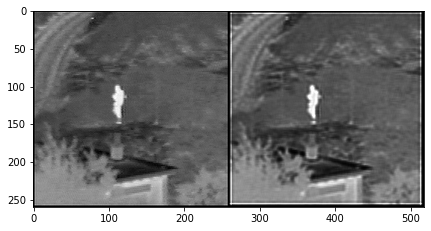

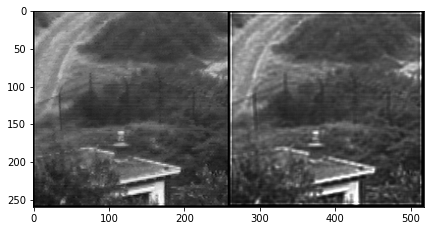

In [4]:
#Test simplest deconvolution
import skimage.restoration as rst
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=32)
us_noisy_np = pil_to_np(us_noisy_pil)

mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=32)
mr_noisy_np = pil_to_np(mr_noisy_pil)

psf = np.ones((5,5))/25

deconvolved_us = rst.richardson_lucy (us_noisy_np[0,:,:], psf, iterations=5)[None,:,:] #deconvolution
deconvolved_mr = rst.richardson_lucy (mr_noisy_np[0,:,:], psf, iterations=5)[None,:,:]

plot_image_grid([us_noisy_np,deconvolved_us], 4, 5)
plot_image_grid([mr_noisy_np,deconvolved_mr], 4, 5)

#original images
o_us_np = us_noisy_np 
o_mr_np = mr_noisy_np

us_noisy_np = deconvolved_us
us_noisy_pil = np_to_pil(deconvolved_us)
mr_noisy_np = deconvolved_mr
mr_noisy_pil = np_to_pil(deconvolved_mr)


In [5]:
#Test estimate PSF and H
import skimage.restoration as rst
import scipy
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=32)
us_noisy_np = pil_to_np(us_noisy_pil)
print(us_noisy_np)

mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=32)
mr_noisy_np = pil_to_np(mr_noisy_pil)

psf_size = [5,5]

us_H, us_psf = estimatePSF(us_noisy_np[0], psf_size)
mr_H, mr_psf = estimatePSF(mr_noisy_np[0], psf_size)
us_psf = us_psf/np.sum(us_psf)
mr_psf = mr_psf/np.sum(mr_psf)

us_psf_np = us_psf[None,:] #numpy is [1,*,*] rather than [*,*]
mr_psf_np = mr_psf[None,:]
us_psf_torch = np_to_torch(us_psf_np).type(dtype).to(device = 'cuda')
mr_psf_torch = np_to_torch(mr_psf_np).type(dtype).to(device = 'cuda')

#torch convolution
# a = torch.nn.functional.conv2d(us_noisy_torch,us_psf_torch,padding = 2)


#cannot operation on GPU, but pytorch has convolution operation
# us_after_psf = scipy.ndimage.filters.correlate(us_noisy_np[0], us_psf, mode='mirror')[None,:,:] 
# us_after_psf = scipy.ndimage.filters.convolve(us_noisy_np[0], us_psf, mode='mirror')[None,:,:]
# plot_image_grid([us_noisy_np,us_after_psf], 4, 5) #should be blurer, cause this is operation on output rather than input


#Deconvolution richardson_lucy

# deconvolved_us = rst.richardson_lucy (us_noisy_np[0,:,:], us_psf, iterations=5)[None,:,:] #deconvolution
# deconvolved_mr = rst.richardson_lucy (mr_noisy_np[0,:,:], mr_psf, iterations=5)[None,:,:]

# plot_image_grid([us_noisy_np,deconvolved_us], 4, 5)
# plot_image_grid([mr_noisy_np,deconvolved_mr], 4, 5)

# #original images
# o_us_np = us_noisy_np 
# o_mr_np = mr_noisy_np

# us_noisy_np = deconvolved_us
# us_noisy_pil = np_to_pil(deconvolved_us)
# mr_noisy_np = deconvolved_mr
# mr_noisy_pil = np_to_pil(deconvolved_mr)


[[[0.30196078 0.31372549 0.31372549 ... 0.34509804 0.33333333 0.3372549 ]
  [0.28627451 0.28627451 0.29019608 ... 0.35294118 0.30980392 0.30588235]
  [0.2745098  0.29803922 0.30980392 ... 0.31372549 0.3254902  0.34509804]
  ...
  [0.52941176 0.51764706 0.54117647 ... 0.5254902  0.50588235 0.50588235]
  [0.58039216 0.55686275 0.54117647 ... 0.5372549  0.5372549  0.52941176]
  [0.56470588 0.54117647 0.53333333 ... 0.54509804 0.55686275 0.56078431]]]
(256, 256)
(256, 256)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:219.)


# **Compute sensor gain**

In [6]:
# As we don't have ground truth
us_pil = us_noisy_pil
us_np = us_noisy_np

mr_pil = mr_noisy_pil
mr_np = mr_noisy_np

#compute sensor gain
# sensor_gain
us_sg, mr_sg = sensor_gain(us_np[0],mr_np[0],d=32)
print(us_sg)
print(mr_sg)
us_sg_np = us_sg[None,:] #numpy is [1,*,*] rather than [*,*]
mr_sg_np = mr_sg[None,:]
us_sg_torch = np_to_torch(us_sg_np).type(dtype).to(device = 'cuda')
mr_sg_torch = np_to_torch(mr_sg_np).type(dtype).to(device = 'cuda')

[[0.44444292 0.44444292 0.44444292 ... 0.44444292 0.44444292 0.44444292]
 [0.44444292 0.44444292 0.44444292 ... 0.44444292 0.44444292 0.44444292]
 [0.44444292 0.44444292 0.44444292 ... 0.44444292 0.44444292 0.44444292]
 ...
 [0.1672851  0.1672851  0.1672851  ... 0.1672851  0.1672851  0.1672851 ]
 [0.1672851  0.1672851  0.1672851  ... 0.1672851  0.1672851  0.1672851 ]
 [0.1672851  0.1672851  0.1672851  ... 0.1672851  0.1672851  0.1672851 ]]
[[0.89580717 0.89580717 0.89580717 ... 0.89580717 0.89580717 0.89580717]
 [0.89580717 0.89580717 0.89580717 ... 0.89580717 0.89580717 0.89580717]
 [0.89580717 0.89580717 0.89580717 ... 0.89580717 0.89580717 0.89580717]
 ...
 [0.98590856 0.98590856 0.98590856 ... 0.98590856 0.98590856 0.98590856]
 [0.98590856 0.98590856 0.98590856 ... 0.98590856 0.98590856 0.98590856]
 [0.98590856 0.98590856 0.98590856 ... 0.98590856 0.98590856 0.98590856]]


In [ ]:
#Test
a = torch.randn(1,2,3)
b = torch.randn(1,2,3)
c = a * b #same as np.multiply()
print(a)
print(b)
print(c)
a = np.array([1,2,3,4]).reshape(2,2)
b = np.array([1,2,3,4]).reshape(2,2)
# print(np.dot(a,b))
# print(np.multiply(a,b))

c = np.append(a,b)
c = np.append(c,b)
c = np.array([0.3]*4)

b = np.ones(3)
a = np.random.rand(4,8)
m1 = np.dot(a,a.transpose())
m2 = np.zeros((4,4))

for i in range(a.shape[1]):
    temp_a = a[:,i][:,None]
    m2 += np.dot(temp_a, temp_a.transpose())  

tensor([[[ 0.8214, -0.3801, -0.0231],
         [-0.6850,  0.7289, -0.5286]]])
tensor([[[ 0.1383,  0.7156, -1.9230],
         [-0.6008, -1.1040,  1.2987]]])
tensor([[[ 0.1136, -0.2720,  0.0444],
         [ 0.4116, -0.8047, -0.6865]]])


# Setup For MR and US


In [12]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99


num_iter = 1000
input_depth = 1
figsize = 5 

net = skip(
            input_depth, 1, 
            num_channels_down = [8, 16, 32, 64, 128], 
            num_channels_up   = [8, 16, 32, 64, 128],
            num_channels_skip = [0, 0, 0, 4, 4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)

#net input is white noise
net_input = get_noise(input_depth, INPUT, (us_pil.size[1], us_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

us_noisy_torch = np_to_torch(us_noisy_np).type(dtype)
mr_noisy_torch = np_to_torch(mr_noisy_np).type(dtype)

Number of params: 572665


## Optimise for MR and US

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


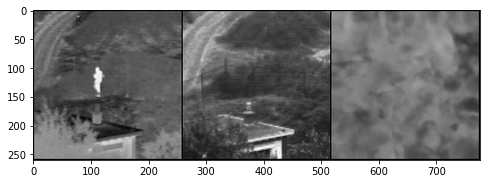

iteration =  0
tensor(0.0801, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


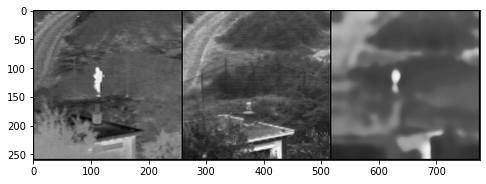

iteration =  100
tensor(0.0664, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


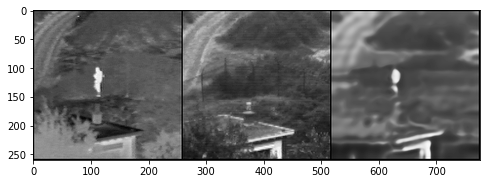

iteration =  200
tensor(0.0655, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


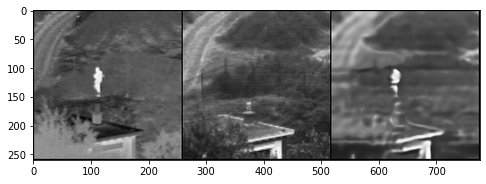

iteration =  300
tensor(0.0653, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


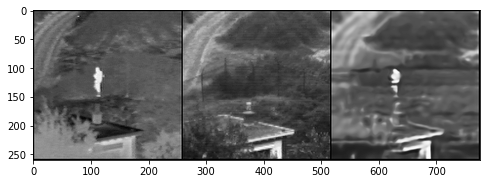

iteration =  400
tensor(0.0651, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


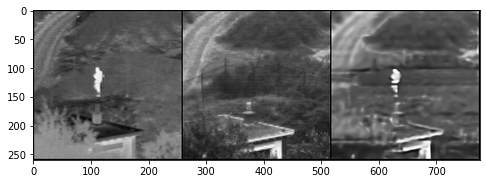

iteration =  500
tensor(0.0651, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


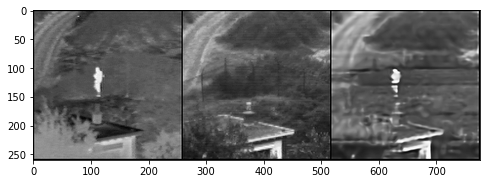

iteration =  600
tensor(0.0650, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


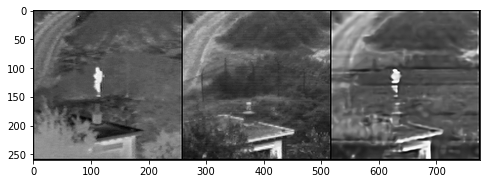

iteration =  700
tensor(0.0650, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


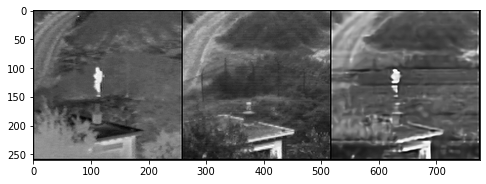

iteration =  800
tensor(0.0650, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


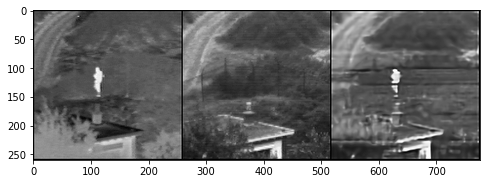

iteration =  900
tensor(0.0649, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [13]:
import skimage.restoration as rst

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
us_para = 0.5
norm_lambda = 1e-6

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input

    #xudong avoid start from the previous running result
    # if reg_noise_std > 0:
    #     net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    # #simplest decovolution -- denosing should be operation on observed images rather than output
    # np_out = torch_to_np(out)[0,:,:]
    # deconvolved_out = rst.richardson_lucy (np_out, psf, iterations=20)[None,None,:,:] #denoising
    # deconvolved_out = torch.tensor(deconvolved_out, requires_grad=True).type(dtype).to(device = 'cuda')
    
    #weighting of US and MR  mean square error  
    total_loss = us_para * mse(us_sg_torch * torch.nn.functional.conv2d(out,us_psf_torch,padding = 2), us_noisy_torch) + (1 - us_para) * mse(mr_sg_torch * torch.nn.functional.conv2d(out,mr_psf_torch,padding = 2), mr_noisy_torch) 
    # print('loss:',total_loss)
    #Adding norm
    total_loss += norm_lambda * torch.norm(out, p = 1) #frobenuis norm
    # print('loss with norm:',total_loss)
    
    total_loss.backward()
        
    
    ####only us image
    # psrn_noisy = compare_psnr(us_noisy_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt    = compare_psnr(us_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt_sm = compare_psnr(us_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    # print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([us_np,mr_np,torch_to_np(out)], factor=figsize, nrow=4)
        # plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        print("iteration = ",i)
        print(total_loss)
        # plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(out_np, 0, 1), 
        #                  np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        
        
    
    # Backtracking
    # if i % show_every:
    #     if psrn_noisy - psrn_noisy_last < -5: 
    #         print('Falling back to previous checkpoint.')

    #         for new_param, net_param in zip(last_net, net.parameters()):
    #             net_param.data.copy_(new_param.cuda())

    #         return total_loss*0
    #     else:
    #         last_net = [x.detach().cpu() for x in net.parameters()]
    #         psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
import inspect
# print(inspect.getsource(crop_image))
print(inspect.getsourcefile(crop_image))
print(inspect.getsource(np_to_pil))


/content/utils/common_utils.py
def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)



In [ ]:
out_np = torch_to_np(net(net_input))
# q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
#Test
a = abs(np.random.randn(2,2))
print(a)
b = np.square(a)
c = np.sqrt(b)
print(b)
print(c)


[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]
[[4.48903262 1.38034368]
 [0.36701177 0.53842659]]
[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]


In [ ]:
import matlab.engine
import numpy as np
from utils.common_utils import *
size = 6

a = np.ones(size**2).reshape(size,size)
b = np.ones(size**2).reshape(size,size)
[sg1, sg2] = sensor_gain(a,b,2)

mat_a = matlab.double(a.tolist())
mat_b = matlab.double(b.tolist())

eng = matlab.engine.start_matlab()
beta = eng.SensorGain(mat_a,mat_b) #only return the first variable
print(sg1)
print(beta)


[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475]]


(1, 512, 512)
(1, 512, 512)


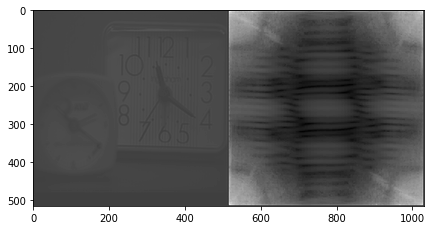

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.05057245e-02, ...,
         1.02547060e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 3.17448162e-04, ...,
         1.04729402e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [ ]:
import numpy as np
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import matplotlib.pyplot as plt

print(us_noisy_np.shape)

# a = np.random.randn(2,3)
a = us_noisy_np
c = np.log(abs(np.fft.fft2(a[0])))
deltaC = c - medfilt2d(c)
lamb = 0.05*abs(deltaC)
r = np.sign(deltaC)*np.maximum(0,abs(deltaC)-lamb)
gr = c - r
# plt.plot(gr)

sigma_est = estimate_sigma(gr) 
im_visushrink = denoise_wavelet(gr, method = 'VisuShrink',mode = 'soft',wavelet_levels = 3,sigma = sigma_est,rescale_sigma=True)[None,:,:]
print(im_visushrink.shape)
plot_image_grid([a,im_visushrink], 4, 5)


In [ ]:

import torch.nn as nn
import torch
 
 
im = torch.randn(1, 1, 5, 5)
print(im.shape)
c = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=1)
output = c(im)
print(torch.norm(output,p=1))
 


torch.Size([1, 1, 5, 5])
tensor(2.9032, grad_fn=<NormBackward1>)
